In [2]:
import numpy as np
####################################################################################################
               # HELPER FUNCTIONS FOR THE NOTEBOOK
####################################################################################################

def frobenius_norm_difference(A, B):
    """
        Calculates the Frobenius norm of the difference between two matrices.
    """
    return np.linalg.norm(A - B, 'fro') / np.linalg.norm(A, 'fro') * 100

def sample_covariance_estimator(X):
    """
        Estimates the sample covariance matrix of a data matrix.
    """
    n = X.shape[1]
    covariance_matrix = np.dot(X, X.T) / n
    
    return covariance_matrix

def generate_low_rank_data(n_features, n_samples, rank):
    """
    Generates a low rank data matrix.
    """
    rank = min(rank, n_features, n_samples)
    A = np.random.randn(n_features, rank) @ np.random.randn(rank, n_samples)
    
    return A



def compare_eigenvalues(eigvals_sample, eigvals_nystrom):
    relative_error = np.linalg.norm(eigvals_sample - eigvals_nystrom) / np.linalg.norm(eigvals_sample)
    return relative_error

def compare_eigenvectors(eigvecs_sample, eigvecs_nystrom, k):
    eigvecs_sample = eigvecs_sample[:, :k]
    eigvecs_nystrom = eigvecs_nystrom[:, :k]
    # Adjust signs
    for i in range(eigvecs_sample.shape[1]):
        if np.dot(eigvecs_sample[:, i], eigvecs_nystrom[:, i]) < 0:
            eigvecs_nystrom[:, i] *= -1
    
    frobenius_norm = np.linalg.norm(eigvecs_sample - eigvecs_nystrom, 'fro') / np.linalg.norm(eigvecs_sample, 'fro')
    return frobenius_norm

####################################################################################################
                # NYSTROM COVARIANCE ESTIMATOR
####################################################################################################
def nystrom_covariance_estimator(X, indices):
    """
    Estimates the covariance matrix of a data matrix using the Nyström method.

    Parameters:
    -----------
    X : numpy.ndarray
        The input data matrix of shape (n, p), where n is the number of samples
        and p is the number of features.
    indices : numpy.ndarray
        The indices of the landmark points to be used in the Nyström method.

    Returns:
    --------
    Sigma_hat : numpy.ndarray
        The estimated covariance matrix of shape (p, p).
    """
    n, p = X.shape      # n: number of samples, p: number of features

    # Step 1: Use the provided landmark indices
    Y = X[:, indices]      # Y.shape = (n, num_landmarks)

    # Step 2: Compute the orthogonal projection matrix P using the pseudoinverse
    YTY = Y.T @ Y
    YTY_pinv = np.linalg.pinv(YTY)
    P = Y @ (YTY_pinv @ Y.T)    # P.shape = (n, n)

    
    Sigma_hat = X.T @ P @ X / n    # Sigma_hat.shape = (p, p)
    
    return Sigma_hat

####################################################################################################
                # NYSTROM PRINCIPAL COMPONENT ANALYSIS 
####################################################################################################
def nystrom_pca(X, num_landmarks):
    """
        Estimates the principal components of a data matrix using the Nyström method.
    """
    p, n = X.shape  # p: number of features, n: number of samples

    # Step 1: Select landmark points (randomly select num_landmarks columns)
    indices_I = np.random.choice(p, num_landmarks, replace=False)
    Y = X[indices_I, :]  # X_I.shape = (num_landmarks, n)

    # Step 2: Define J and X_J
    indices_J = np.setdiff1d(np.arange(p), indices_I)
    Z = X[indices_J, :]  # X_J.shape = (p - num_landmarks, n)

    # Step 3: Compute Thin SVD of X_I
    U_Y, D_Y, V_Y_T = np.linalg.svd(Y, full_matrices=False)
    # Step 4: Construct W_I and W_J
    W_Y = (1 / np.sqrt(n)) * U_Y @ np.diag(D_Y)
    W_Z = (1 / np.sqrt(n)) * Z @ V_Y_T.T

    # Initialize W with the same shape as X
    W = np.zeros((p, num_landmarks))
    W[indices_I, :] = W_Y
    W[indices_J, :] = W_Z

    # Step 6: Perform thin SVD on W
    U, Lambda, V_T = np.linalg.svd(W, full_matrices=False)

    # Eigenvalues and eigenvectors
    eigenvalues = Lambda**2
    eigenvectors = U

    return eigenvalues, eigenvectors

####################################################################################################
                # EXAMPLE USAGE
####################################################################################################

p, n, rank = 10, 10, 3  # Number of features, number of samples, rank of the data matrix
X = generate_low_rank_data(p, n, rank)  # Generate a low rank data matrix  

# Sample covariance matrix
Sigma_simple = sample_covariance_estimator(X)

# Nyström covariance estimator
num_landmarks = 3  # Number of landmark points
Sigma_nystrom = nystrom_covariance_estimator(X, num_landmarks)

# Nyström PCA
k = 3  # Number of principal components
eigvals_pca, eigvecs_pca = nystrom_pca(X, num_landmarks)

# Assuming Sigma_nystrom is already defined and is a square symmetric matrix
eigenvalues, eigenvectors = np.linalg.eig(Sigma_simple)

# Compare the eigenvalues and eigenvectors
#relative_error_eigenvalues = compare_eigenvalues(eigvals_pca, eigenvalues)
#frobenius_norm_eigenvectors = compare_eigenvectors(eigvecs_pca, eigenvectors)


In [13]:
print("Eigenvalues of PCA Matrix: ", eigvals_pca)
print("Eigenvectors of PCA Matrix: ",eigvecs_pca)

Eigenvalues of PCA Matrix:  [8.16580301 5.56778616 0.83176086]
Eigenvectors of PCA Matrix:  [[-0.16439848  0.01923894  0.55381899]
 [ 0.01428999  0.23826268 -0.09133154]
 [ 0.04489091  0.25854273 -0.15528452]
 [-0.15447217 -0.10550825 -0.41332448]
 [-0.02921605  0.26768149 -0.35050209]
 [-0.29743765 -0.44859298 -0.4780668 ]
 [-0.03205207 -0.34649639  0.26777043]
 [-0.65909537  0.35519862  0.19801629]
 [-0.27845713  0.47679944 -0.16173892]
 [-0.5870238  -0.34413932  0.03901484]]


In [15]:

# Sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]  # Reversing to sort from largest to smallest

# Sort eigenvalues and eigenvectors according to the sorted indices
sorted_eigenvalues = eigenvalues[sorted_indices].real
sorted_eigenvectors = eigenvectors[:, sorted_indices].real
print("Eigenvectors of PCA Matrix: ", compare_eigenvectors(eigvecs_pca, sorted_eigenvectors, k))

Eigenvectors of PCA Matrix:  1.008933228589396e-15


In [4]:
def nystrom_pca(X, num_landmarks):
    """
        Estimates the principal components of a data matrix using the Nyström method.
    """
    p, n = X.shape  # p: number of features, n: number of samples
    print(X.shape)

    # Step 1: Select landmark points (randomly select num_landmarks columns)
    indices_I = np.random.choice(p, num_landmarks, replace=False)
    Y = X[indices_I, :]  # X_I.shape = (num_landmarks, n)

    # Step 2: Define J and X_J
    indices_J = np.setdiff1d(np.arange(p), indices_I)
    Z = X[indices_J, :]  # X_J.shape = (p - num_landmarks, n)

    # Step 3: Compute Thin SVD of X_I
    U_Y, D_Y, V_Y_T = np.linalg.svd(Y, full_matrices=False)
    # Step 4: Construct W_I and W_J
    W_Y = (1 / np.sqrt(n)) * U_Y @ np.diag(D_Y)
    W_Z = (1 / np.sqrt(n)) * Z @ V_Y_T.T

    # Initialize W with the same shape as X
    W = np.zeros((p, num_landmarks))
    W[indices_I, :] = W_Y
    W[indices_J, :] = W_Z

    # Step 6: Perform thin SVD on W
    U, Lambda, V_T = np.linalg.svd(W, full_matrices=False)

    # Eigenvalues and eigenvectors
    eigenvalues = Lambda**2
    eigenvectors = U

    return eigenvalues, eigenvectors

def sample_eigenvalues_eigenmatrices(X):
    """
        Estimates the sample covariance matrix of a data matrix.
    """
    U_Y, D_Y, V_Y_T = np.linalg.svd(X, full_matrices=False)
    eigenvalues = D_Y**2 / n
    eigenvectors = U_Y / n

    
    return eigenvalues, eigenvectors

X = generate_low_rank_data(p, n, rank)  # Generate a low rank data matrix
eigenvalues_sample, eigenvectors_sample = sample_eigenvalues_eigenmatrices(X)

# Sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues_sample)[::-1]  # Reversing to sort from largest to smallest

# Sort eigenvalues and eigenvectors according to the sorted indices
sorted_eigenvalues = eigenvalues_sample[sorted_indices].real
sorted_eigenvectors = eigenvectors_sample[:, sorted_indices].real

print("Eigenvalues of Nystrom Matrix: ", sorted_eigenvalues[:3])
#print("Eigenvectors of Nystrom Matrix: ", sorted_eigenvectors[:, :3])

# PCA using the sample covariance matrix
eigenvalues_pca, eigenvectors_pca = nystrom_pca(X, rank)
print("Eigenvalues of PCA Matrix: ", eigenvalues_pca)
#print("Eigenvectors of PCA Matrix: ", eigenvectors_pca)

# Compare the eigenvalues and eigenvector


Eigenvalues of Nystrom Matrix:  [20.4526705   6.91914782  3.22121577]
(10, 10)
Eigenvalues of PCA Matrix:  [20.4526705   6.91914782  3.22121577]


Finished 10 iterations
Finished 20 iterations
Finished 30 iterations
Finished 40 iterations
Finished 50 iterations


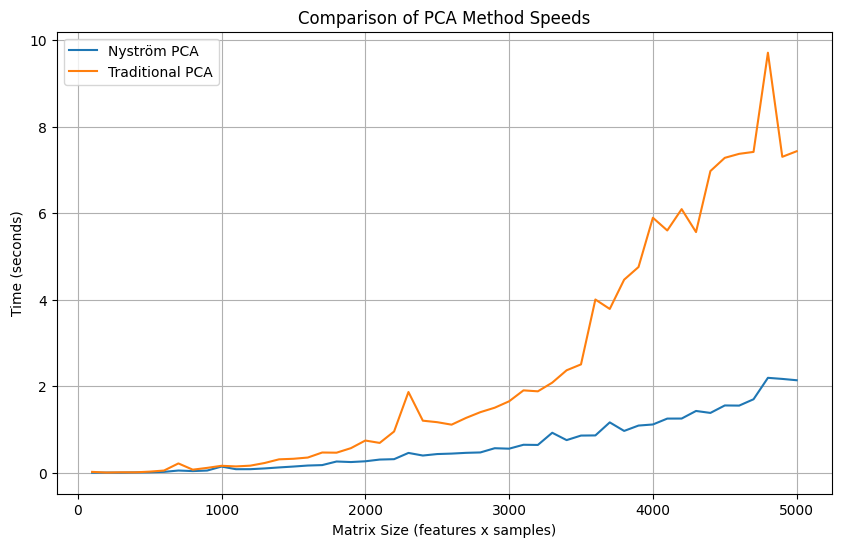

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer


def compare_pca_methods(max_size, step):
    sizes = range(step, max_size + 1, step)
    
    times_nystrom = []
    times_sample = []
    i = 0
    for size in sizes:
        i+=1
        p  = size
        n = size // 2
        rank = size // 5

        # Generate a low rank data matrix
        X = generate_low_rank_data(p, n, rank)

        # Measure Nyström PCA
        start_time = timer()
        nystrom_pca(X, rank)
        end_time = timer()
        times_nystrom.append(end_time - start_time)

        # Measure traditional PCA
        start_time = timer()
        sample_eigenvalues_eigenmatrices(X)
        end_time = timer()
        times_sample.append(end_time - start_time)

        if i%10==0:
            print(f"Finished {i} iterations")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, times_nystrom, label='Nyström PCA')
    plt.plot(sizes, times_sample, label='Traditional PCA')
    plt.xlabel('Matrix Size (features x samples)')
    plt.ylabel('Time (seconds)')
    plt.title('Comparison of PCA Method Speeds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
max_matrix_size = 5000  # maximum size of the matrix
step_size = 100         # step size for increasing​⬤

# Compare the two methods
compare_pca_methods(max_matrix_size, step_size)

In [59]:
p = 4
n = 2
rank = 2
X = generate_low_rank_data(n, p , rank)  # Generate a low rank data matrix

In [81]:
import numpy as np

def nystrom_pca(X, num_landmarks):
    """
        Estimates the principal components of a data matrix using the Nyström method.
    """
    n, p = X.shape  # needs to be n x p
    print("Shape of X", X.shape)
    print("X: ", X)
    print("-------------------")
    # Step 1: Select landmark points (randomly select num_landmarks columns)
    indices_I = [0, 1]
    Y = X[:, indices_I]  # Y = 
    print("Shape of Y: ", Y.shape)
    print("Y: ", Y)
    print("-------------------")

    # Step 2: Define J and X_J
    indices_J = [2, 3]
    Z = X[:, indices_J]  # X_J.shape = (p - num_landmarks, n)
    print("Shape of Z: ", Z.shape)
    print("Z: ", Z)
    print("-------------------")

    # Step 3: Compute Thin SVD of X_I
    U_Y, D_Y, V_Y_T = np.linalg.svd(Y, full_matrices=False)
    print("U_Y Shape: ", U_Y.shape)
    print("U_Y: ", U_Y)
    print("-------------------")

    print("D_Y Shape: ", np.diag(D_Y).shape)
    print("D_Y: ", np.diag(D_Y))
    print("-------------------")
    print("V_Y_T Shape: ", V_Y_T.shape)
    print("V_Y_T: ", V_Y_T)
    print("-------------------")
    # Step 4: Construct W_I and W_J
    W_Y = (1 / np.sqrt(n)) * np.diag(D_Y) @ V_Y_T
    print("W_Y Shape ", W_Y.shape)
    print("W_Y: ", W_Y)
    print("-------------------")
    W_Z = (1 / np.sqrt(n)) * U_Y.T @ Z
    print("W_Z, Shape:",W_Z.shape)
    print("W_Z: ", W_Z)
    print("-------------------")

    # Initialize W with the same shape as X
    W = np.zeros((num_landmarks, p)) # needs to be num_landmarks x p
    W[:, indices_I] = W_Y
    W[:, indices_J] = W_Z
    print("Shape of W: ", W.shape)
    print("W: ", W)
    print("-------------------")
    U, Lambda, V_T = np.linalg.svd(W, full_matrices=False)

    Sigma = np.dot(W.T, W) # Needs to be W.T x W
    print("Sigma Shape: ", Sigma.shape)
    print("Sigma: ", Sigma)
    print("-------------------")

    eigenvalues = Lambda**2
    print("Eigenvalues: ", eigenvalues)
    print("-------------------")
    eigenvectors = V_T.T
    print("Eigenvectors: ", eigenvectors)
    print("-------------------")


    return Sigma, eigenvalues, eigenvectors
changed_sigma = nystrom_pca(X, 2)

Shape of X (2, 4)
X:  [[-0.04741444  0.00582203 -1.5595836   0.08794247]
 [ 0.07869833 -0.057843    1.47541121 -0.0689165 ]]
-------------------
Shape of Y:  (2, 2)
Y:  [[-0.04741444  0.00582203]
 [ 0.07869833 -0.057843  ]]
-------------------
Shape of Z:  (2, 2)
Z:  [[-1.5595836   0.08794247]
 [ 1.47541121 -0.0689165 ]]
-------------------
U_Y Shape:  (2, 2)
U_Y:  [[-0.40887863  0.91258877]
 [ 0.91258877  0.40887863]]
-------------------
D_Y Shape:  (2, 2)
D_Y:  [[0.10659253 0.        ]
 [0.         0.02143123]]
-------------------
V_Y_T Shape:  (2, 2)
V_Y_T:  [[ 0.85565063 -0.51755386]
 [-0.51755386 -0.85565063]]
-------------------
W_Y Shape  (2, 2)
W_Y:  [[ 0.06449235 -0.03900922]
 [-0.0078431  -0.01296668]]
-------------------
W_Z, Shape: (2, 2)
W_Z:  [[ 1.40298761 -0.06989766]
 [-0.57982358  0.03682388]]
-------------------
Shape of W:  (2, 4)
W:  [[ 0.06449235 -0.03900922  1.40298761 -0.06989766]
 [-0.0078431  -0.01296668 -0.57982358  0.03682388]]
-------------------
Sigma Shape

In [75]:
print(frobenius_norm_difference(changed_sigma, original_sigma))

3.83953640272633e-14


In [80]:
def nystrom_pca(X, num_landmarks):
    """
        Estimates the principal components of a data matrix using the Nyström method.
    """
    p, n = X.shape  # p: number of features, n: number of samples
    print("Shape of X", X.shape)
    print("X: ", X)
    print("-------------------")

    # Step 1: Select landmark points (randomly select num_landmarks columns)
    indices_I = [0, 1]
    Y = X[indices_I, :]  # X_I.shape = (num_landmarks, n)
    print("Shape of Y", Y.shape)
    print("Y: ", Y)
    print("-------------------")

    # Step 2: Define J and X_J
    indices_J = [2, 3]
    Z = X[indices_J, :]  # X_J.shape = (p - num_landmarks, n)
    print("Shape of Z", Z.shape)
    print("Z: ", Z)
    print("-------------------")

    # Step 3: Compute Thin SVD of X_I
    U_Y, D_Y, V_Y_T = np.linalg.svd(Y, full_matrices=False)
    print("Shape of U_Y", U_Y.shape)
    print("U_Y: ", U_Y)
    print("-------------------")

    print("Shape of D_Y", np.diag(D_Y).shape)
    print("D_Y: ", np.diag(D_Y))
    print("-------------------")

    print("Shape of V_Y_T", V_Y_T.shape)
    print("V_Y_T: ", V_Y_T)
    print("-------------------")

    # Step 4: Construct W_I and W_J
    W_Y = (1 / np.sqrt(n)) * U_Y @ np.diag(D_Y)
    print("Shape of W_Y", W_Y.shape)
    print("W_Y: ", W_Y)
    print("-------------------")

    W_Z = (1 / np.sqrt(n)) * Z @ V_Y_T.T
    print("Shape of W_Z", W_Z.shape)
    print("W_Z: ", W_Z)
    print("-------------------")

    # Initialize W with the same shape as X
    W = np.zeros((p, num_landmarks))
    print("Shape of W", W.shape)
   
    print("-------------------")
    W[indices_I, :] = W_Y
    W[indices_J, :] = W_Z
    print("W: ", W)

    Sigma = np.dot(W, W.T)
    print("Shape of Sigma", Sigma.shape)
    print("Sigma: ", Sigma)
    print("-------------------")
    # Step 6: Perform thin SVD on W
    U, Lambda, V_T = np.linalg.svd(W, full_matrices=False)

    # Eigenvalues and eigenvectors
    eigenvalues = Lambda**2
    print("Eigenvalues: ", eigenvalues)
    print("-------------------")
    eigenvectors = U
    print("Eigenvectors: ", eigenvectors)
    print("-------------------")

    return Sigma

original_sigma = nystrom_pca(X.T, rank)

Shape of X (4, 2)
X:  [[-0.04741444  0.07869833]
 [ 0.00582203 -0.057843  ]
 [-1.5595836   1.47541121]
 [ 0.08794247 -0.0689165 ]]
-------------------
Shape of Y (2, 2)
Y:  [[-0.04741444  0.07869833]
 [ 0.00582203 -0.057843  ]]
-------------------
Shape of Z (2, 2)
Z:  [[-1.5595836   1.47541121]
 [ 0.08794247 -0.0689165 ]]
-------------------
Shape of U_Y (2, 2)
U_Y:  [[-0.85565063  0.51755386]
 [ 0.51755386  0.85565063]]
-------------------
Shape of D_Y (2, 2)
D_Y:  [[0.10659253 0.        ]
 [0.         0.02143123]]
-------------------
Shape of V_Y_T (2, 2)
V_Y_T:  [[ 0.40887863 -0.91258877]
 [-0.91258877 -0.40887863]]
-------------------
Shape of W_Y (2, 2)
W_Y:  [[-0.06449235  0.0078431 ]
 [ 0.03900922  0.01296668]]
-------------------
Shape of W_Z (2, 2)
W_Z:  [[-1.40298761  0.57982358]
 [ 0.06989766 -0.03682388]]
-------------------
Shape of W (4, 2)
-------------------
W:  [[-0.06449235  0.0078431 ]
 [ 0.03900922  0.01296668]
 [-1.40298761  0.57982358]
 [ 0.06989766 -0.03682388]]